# Лабораторная работа №1

Я выбрал для работы научные публикации связанные с темой **Gambling**

## Выгрузка данных

In [9]:
import requests
import xml.etree.ElementTree as ET
import json
import os
import time

API = "http://export.arxiv.org/api/query"
THEME = "gambling"
OUTPUT_FILE = "gambling_data.json"
MAX_DATA_SIZE = 500

def get_gambling_data_xml(start=0, batch_size=100):
    query = f"search_query=all:{THEME}&start={start}&max_results={batch_size}"
    url = f"{API}?{query}"

    response = requests.get(url)
    response.raise_for_status()

    root = ET.fromstring(response.content)

    return root

def read_xml(xml_root: ET.Element, output: list):
    namespace = {"atom": "http://www.w3.org/2005/Atom"}
    rows_added = 0
    for entry in xml_root.findall('atom:entry', namespace):
        authors = entry.findall('atom:author', namespace)
        row = {
            "title": entry.find('atom:title', namespace).text,
            "id": entry.find('atom:id', namespace).text,
            "published": entry.find('atom:published', namespace).text,
            "summary": entry.find('atom:summary', namespace).text,
            "authors": [author.find('atom:name', namespace).text for author in authors]
        }
        output.append(row)
        rows_added += 1
    return rows_added

def fetch_gambling_data(output_file=OUTPUT_FILE):
    batch_size = 100
    total_rows = 0
    data = []

    while total_rows < MAX_DATA_SIZE:
        print(f"Fetching data from {total_rows} to {total_rows + batch_size}")
        xml_root = get_gambling_data_xml(total_rows, batch_size)
        rows_added = read_xml(xml_root, data)
        if rows_added == 0:
            print("No more data found, exiting")
            break

        total_rows += rows_added
        print(f"Added {rows_added} rows to {output_file}, total rows: {total_rows}")
        time.sleep(1)
    
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)

fetch_gambling_data()

Fetching data from 0 to 100
Added 100 rows to gambling_data.json, total rows: 100
Fetching data from 100 to 200
Added 100 rows to gambling_data.json, total rows: 200
Fetching data from 200 to 300
Added 100 rows to gambling_data.json, total rows: 300
Fetching data from 300 to 400
Added 100 rows to gambling_data.json, total rows: 400
Fetching data from 400 to 500
Added 61 rows to gambling_data.json, total rows: 461
Fetching data from 461 to 561
No more data found, exiting


## Выделение ключевых слов и построение связи между ними

Объединим название и описание в один текст

In [1]:
import json

with open('gambling_data.json', 'r') as f:
    articles = json.load(f)

data = [article['title'] + ' ' + article['summary'] for article in articles]

Воспользуемся алгоритмом TF-IDF, чтобы получить топ N ключевых слов для каждой статьи

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

TOP_N = 15

vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data)
all_keywords = vectorizer.get_feature_names_out()

articles_keywords = []
for i in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix.getrow(i)
    indices = np.argsort(row.toarray()[0])[-TOP_N:][::-1]
    keywords = [all_keywords[idx] for idx in indices]
    articles_keywords.append(keywords)


[['gambling',
  'problem',
  'communities',
  'online',
  'diagnostic',
  'annotation',
  'bert',
  'manual',
  'signs',
  'criteria',
  'data',
  'achieved',
  'major',
  'training',
  'users'],
 ['gambling',
  'attitudes',
  'risk',
  'understanding',
  'casino',
  'blockchain',
  'bet',
  'winning',
  'dataset',
  'data',
  'behavior',
  'betting',
  'progress',
  'publishes',
  'timestamp'],
 ['fraud',
  'synthetic',
  'gambling',
  'online',
  'gan',
  'gans',
  'laundering',
  'increasingly',
  'data',
  'generation',
  'money',
  'detection',
  'manages',
  'sdg',
  'complementing'],
 ['gacha',
  'severity',
  'research',
  'mobile',
  'games',
  'gambling',
  'game',
  'regression',
  'affect',
  'directly',
  'demonstrated',
  'players',
  'findings',
  'behavior',
  'pgsi'],
 ['risk',
  'psychology',
  'ai',
  'behavioral',
  'gambling',
  'behaviors',
  'tendencies',
  'chasing',
  'taking',
  'mitigating',
  'overconfidence',
  'loss',
  'aware',
  'like',
  'exhibit'],
 ['

Построим граф связей между ключевыми статьями с помощью networkx

In [8]:
import networkx as nx
from itertools import combinations

G = nx.Graph()

for keywords in articles_keywords:
    for u, v in combinations(keywords, 2):
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)

Визуализируем полученный граф

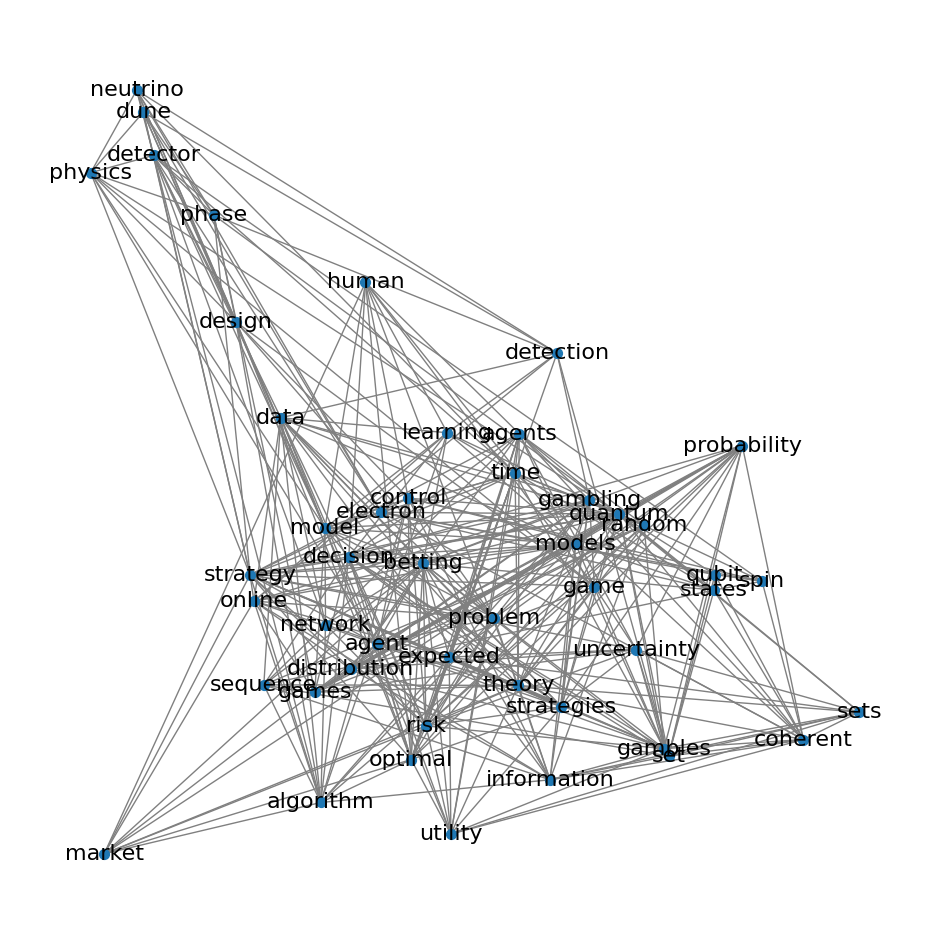

In [17]:
import matplotlib.pyplot as plt

MIN_DEGREE = 120

nodes_to_keep = [node for node, degree in dict(G.degree()).items() if degree > MIN_DEGREE]
subG = G.subgraph(nodes_to_keep).copy()

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx(subG, pos, with_labels=True, font_size=16, node_size=50, edge_color='gray')
plt.axis('off')
plt.show()